# Simple Moving Average Trading Strategy Notebook 📈

## Setup Instructions

### Step 1: Environment Setup
1. This notebook runs on Google Colab
2. Make sure you're connected to a runtime (check top right corner)
3. Required libraries will be installed automatically in the first code cell

### Step 2: Required Libraries
The notebook uses the following main libraries:
- pandas: for data manipulation
- ta: for technical analysis indicators
- matplotlib/plotly: for visualization
- numpy: for numerical operations

### Step 3: Data Collection & Import
1. Visit [Our Trading Strategy Builder Platform](https://interactive-template.d21r6l0i22ce7a.amplifyapp.com/market-data.html)
2. Select your desired:
   - Market
   - Trading Symbol
   - Timeframe
3. Download the CSV file to your local machine
4. Upload to Google Colab:
   - Click the folder icon in the left sidebar
   - Choose "Upload to session storage"
   - Select your downloaded CSV file

### Step 4: Running the Notebook
1. Run cells in order (Shift + Enter or press play button)
2. Wait for each cell to complete before running the next one
3. If you see a warning about "Running on a GPU", you can ignore it for this analysis

### Data Processing Steps
1. Technical Analysis: Calculating various indicators (RSI, EMA, etc.)
2. Data Visualization: Creating interactive charts and plots
3. Analysis Results: Viewing and interpreting the results

### Important Notes
- Make sure to check for any missing values in your data
- All timestamps are in UTC
- Price data includes Open, High, Low, Close values


### Troubleshooting
If you encounter errors:
1. Check if all cells were executed in order
2. Verify that data files are properly loaded
3. Restart the runtime if needed (Runtime → Restart runtime)

### Need Help?
- Check the comments in each code cell for detailed explanations
- Refer to the documentation links provided in the notebook
- Contact [Link to contact form] for support

---
*Last Updated: November 2024*

# 1) Install packages and import libraries

In [26]:
# Install the Technical Analysis (ta) library
# This library provides tools for calculating financial indicators like RSI, EMA, MACD, etc.
# Only needs to be run once per Colab session
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=402b9d45a2bb5d40aa90322655d1d7b41e816d7aa6505b1f2a29cdb97cecc856
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [38]:
# Import necessary libraries:
# - pandas (pd): for data manipulation and analysis
# - ta: Technical Analysis library for calculating trading indicators (RSI, EMA, etc.)
import pandas as pd
import ta

# 2) Import data

In [52]:
# Read and display the forex data:
# 1. Load the CSV file containing EUR/USD 1-minute data into a pandas DataFrame
# 2. Convert explicitly to DataFrame format (though read_csv already returns a DataFrame)
# 3. Display the first 5 rows of the data using .head()
forex_EURUSD_1min = pd.read_csv('forex_EURUSD=X_1min.csv')
forex_EURUSD_1min=pd.DataFrame(forex_EURUSD_1min)
forex_EURUSD_1min.head()

,datetime,datetime,price,price.1,price.2,price.3,DATETIME
0,first,last,first,max,min,last,NaN
1,2024-10-29 19:49:58.426130,2024-10-29 19:49:59.692075,1.081439971923828,1.081439971923828,1.081380009651184,1.081380009651184,2024-10-29 19:49:00
2,2024-10-29 19:50:00.347931,2024-10-29 19:50:58.378963,1.081380009651184,1.0814100503921509,1.0813299417495728,1.0813699960708618,2024-10-29 19:50:00
3,2024-10-29 19:51:01.238487,2024-10-29 19:51:58.344377,1.0813699960708618,1.0814000368118286,1.0813000202178955,1.0813499689102173,2024-10-29 19:51:00
4,2024-10-29 19:52:00.375926,2024-10-29 19:52:57.366026,1.0813599824905396,1.0814100503921509,1.081339955329895,1.0813599824905396,2024-10-29 19:52:00


In [53]:
# Clean and format the EUR/USD DataFrame:

# Reset index and remove duplicate datetime columns
forex_EURUSD_1min = forex_EURUSD_1min.reset_index(drop=True)
forex_EURUSD_1min.drop(['datetime','datetime'], axis=1, inplace=True)

# Set up naming convention for the currency pair
thicker='eurusd'

# Define new column names mapping
new_columns = {
   'price': f'{thicker}_first',    # Opening price for the period
   'price.1': f'{thicker}_max',    # Highest price in the period
   'price.2': f'{thicker}_min',    # Lowest price in the period
   'price.3': f'{thicker}_last',   # Closing price for the period
   'DATETIME': 'period start',      # Start time of the period
}

# Rename columns and reorder them
forex_EURUSD_1min = forex_EURUSD_1min.rename(columns=new_columns)
forex_EURUSD_1min=forex_EURUSD_1min[['period start',f'{thicker}_first', f'{thicker}_max', f'{thicker}_min', f'{thicker}_last']]

# Remove header row that contains descriptors and reset index
forex_EURUSD_1min = forex_EURUSD_1min.iloc[1:].reset_index(drop=True)

# Convert price columns to float type for calculations
price_columns = [f'{thicker}_first', f'{thicker}_max', f'{thicker}_min', f'{thicker}_last']
forex_EURUSD_1min[price_columns] = forex_EURUSD_1min[price_columns].astype(float)

# Convert the timestamp column to datetime format
datetime_columns = ['period start']
forex_EURUSD_1min[datetime_columns] = forex_EURUSD_1min[datetime_columns].apply(pd.to_datetime)

# Display the first 5 rows of cleaned data
forex_EURUSD_1min.head()

,period start,eurusd_first,eurusd_max,eurusd_min,eurusd_last
0,2024-10-29 19:49:00,1.08144,1.08144,1.08138,1.08138
1,2024-10-29 19:50:00,1.08138,1.08141,1.08133,1.08137
2,2024-10-29 19:51:00,1.08137,1.08140,1.08130,1.08135
3,2024-10-29 19:52:00,1.08136,1.08141,1.08134,1.08136
4,2024-10-29 19:53:00,1.08135,1.08137,1.08129,1.08132


# 3) Prepare main df and calculate indicators

In [54]:
price_type = 'first'  # Define the type of price data to use, here set to 'first'

# Create a new DataFrame with selected columns: 'period start' and a dynamic column name based on 'thicker' and 'price_type'
df = forex_EURUSD_1min[['period start', f'{thicker}_{price_type}']].copy()

df = df.dropna()  # Remove any rows with missing values

df.head()  # Display the first five rows of the DataFrame to verify the data


,period start,eurusd_first
0,2024-10-29 19:49:00,1.08144
1,2024-10-29 19:50:00,1.08138
2,2024-10-29 19:51:00,1.08137
3,2024-10-29 19:52:00,1.08136
4,2024-10-29 19:53:00,1.08135


In [56]:

def calculate_indicator_sma(df, thicker, price_type, period):
    # Calculate the Simple Moving Average (SMA) over the specified period
    # Adds a new column to df with the format '{thicker}_{price_type}_sma{period}'
    df[f"{thicker}_{price_type}_sma{period}"] = df[f"{thicker}_{price_type}"].rolling(period).mean()
    return df

def calculate_indicator_rsi(df, thicker, price_type, period):
    # Calculate the Relative Strength Index (RSI) over the specified period
    # Uses ta library's RSIIndicator and adds the result as a new column to df
    df[f"{thicker}_{price_type}__rsi{period}"] = ta.momentum.RSIIndicator(close=df[f"{thicker}_{price_type}"], window=period).rsi()
    return df

def calculate_indicator_emarsi(df, thicker, price_type, rsiperiod, period):
    # Calculate the Exponential Moving Average (EMA) of the RSI over a specified period
    # Requires the RSI column to be calculated first; adds the result as a new column to df
    df[f"{thicker}_{price_type}__emarsi{period}"] = ta.trend.EMAIndicator(close=df[f"{thicker}_{price_type}__rsi{rsiperiod}"], window=period).ema_indicator()
    return df

# Apply SMA calculation with different periods
df_indic = calculate_indicator_sma(df, thicker, price_type, 10)
df_indic = calculate_indicator_sma(df, thicker, price_type, 52)
df_indic = calculate_indicator_sma(df, thicker, price_type, 100)
df_indic = calculate_indicator_sma(df, thicker, price_type, 200)
df_indic = calculate_indicator_sma(df, thicker, price_type, 300)

# Apply RSI calculation
df_indic = calculate_indicator_rsi(df, thicker, price_type, 14)

# Apply EMA of RSI calculation
df_indic = calculate_indicator_emarsi(df, thicker, price_type, 14, 21)

df_indic.tail()  # Display the last five rows to verify the calculated indicators



,period start,eurusd_first,eurusd_first_sma10,eurusd_first_sma52,eurusd_first_sma100,eurusd_first_sma200,eurusd_first_sma300,eurusd_first__rsi14,eurusd_first__emarsi21
4002,2024-11-01 15:54:00,1.08107,1.081069,1.081282,1.081789,1.082138,1.082410,39.589853,39.095409
4003,2024-11-01 15:55:00,1.08099,1.081064,1.081276,1.081770,1.082130,1.082403,34.584026,38.685284
4004,2024-11-01 15:56:00,1.08099,1.081059,1.081270,1.081752,1.082123,1.082396,34.584026,38.312442
4005,2024-11-01 15:57:00,1.08102,1.081053,1.081265,1.081733,1.082116,1.082389,37.998632,38.283914
4006,2024-11-01 15:59:00,1.08096,1.081038,1.081258,1.081714,1.082109,1.082382,34.165160,37.909482


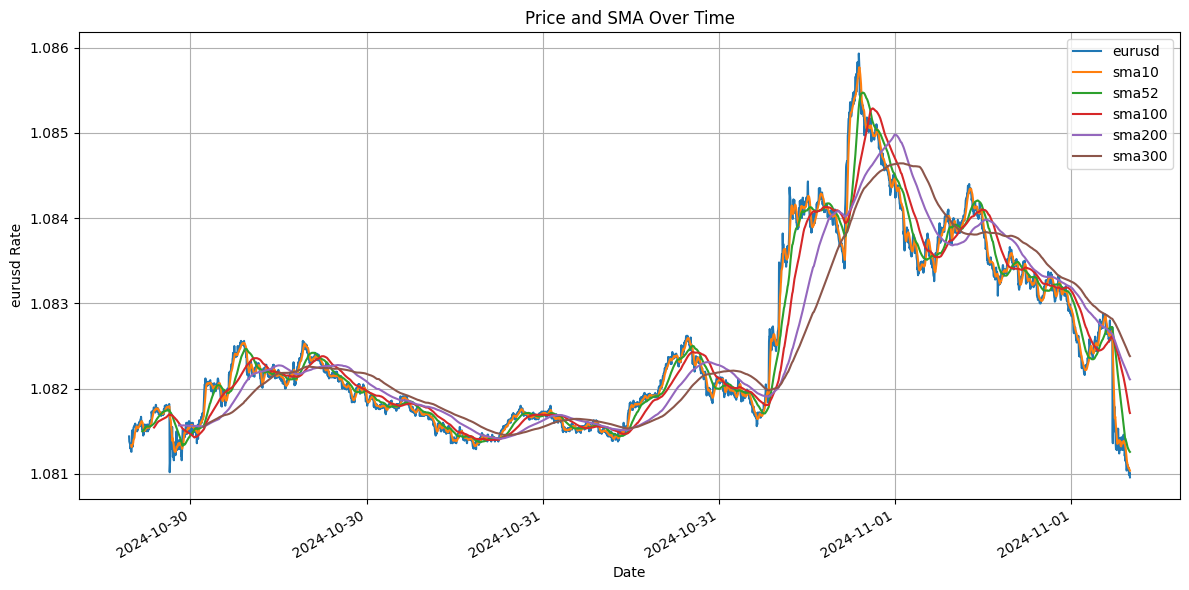

In [57]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Set the 'period start' column as the index to make datetime-based plotting easier
df_indic.set_index('period start', inplace=True)

# Define the indicator type as 'sma' for plotting Simple Moving Averages
indicator = 'sma'

# Initialize the plot with a specific size
plt.figure(figsize=(12, 6))

# Plot the original price data
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}'], label=f'{thicker}')

# Plot different SMA indicators with various periods on the same chart
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}_{indicator}10'], label=f'{indicator}10')
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}_{indicator}52'], label=f'{indicator}52')
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}_{indicator}100'], label=f'{indicator}100')
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}_{indicator}200'], label=f'{indicator}200')
plt.plot(df_indic.index, df_indic[f'{thicker}_{price_type}_{indicator}300'], label=f'{indicator}300')

# Add plot title and labels for x and y axes
plt.title(f'Price and {indicator.upper()} Over Time')
plt.xlabel('Date')
plt.ylabel(f'{thicker} Rate')

# Display a legend to identify each line
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Format x-axis to show dates in a readable format
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()


# 4) Define buy/sell conditions

# 5) Analyse results